In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import simpy as sp
import copy

import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
class Simulation(object):

  env: sp.Environment
  object_counter: int
  nxGraph: nx.DiGraph
  objects: dict
  graph: dict 
  sources: dict 
  nodes: dict 
  packets: dict

  ### HYPERPARAMETERS ###
  pedge: float
  graph_constructor: object # lambda - networkx graph generator
  num_sources: int
  num_nodes: int
  node_send_rate_dist: object         # lambda - rng
  node_mutate_prob_dist: object       # lambda - rng
  node_mutate_variance_dist: object   # lambda - rng       
  node_mutate_mean_dist: object       # lambda - rng 
  source_gen_rate_dist: object        # lambda - rng

  def __init__(self : "Simulation"):
    self.env = sp.Environment()
    self.object_counter = 0
    self.packet_counter = 0
    self.objects = dict()
    self.nxGraph = nx.Graph()
    self.graph = dict()
    self.sources = dict()
    self.nodes = dict()
    self.packets = dict()
    self.num_sources = 3
    self.num_nodes = 250
    self.random_graph_generator = lambda: nx.scale_free_graph(self.num_sources + self.num_nodes, 
                                                              beta=self.pedge,
                                                              alpha=(1-self.pedge)/2,
                                                              gamma=(1-self.pedge)/2)
    self.pedge = 0.04
    self.node_send_rate_dist = lambda : np.abs(np.random.normal(scale=0.1))
    self.node_mutate_prob_dist = lambda : np.random.normal()/10  
    self.node_mutate_variance_dist = lambda : 1.0       
    self.node_mutate_mean_dist = lambda : 0.5
    self.source_gen_rate_dist = lambda : np.abs(np.random.normal(scale=0.1))
    
    # Data
    self.spread_count = []
    self.misinfo_count = []

  def generate(self : "Simulation"):
    # Construct actual objects
    for _ in range(self.num_sources):
      source = Source(self)
      self.sources[self.object_counter] = source
      self.objects[self.object_counter] = source
      self.graph[self.object_counter] = set()
      self.object_counter += 1

    for _ in range(self.num_nodes):
      node = Node(self)
      self.nodes[self.object_counter] = node
      self.objects[self.object_counter] = node
      self.graph[self.object_counter] = set()
      self.object_counter += 1

      
    # G_tmp = nx.gnp_random_graph(self.num_sources + self.num_nodes, self.pedge)
    # Construct graph
    G_tmp = nx.scale_free_graph(self.num_sources + self.num_nodes, 
                                beta=self.pedge,
                                alpha=(1-self.pedge)/2,
                                gamma=(1-self.pedge)/2)
    self.nxGraph.add_nodes_from(G_tmp.nodes())
    for u, v in G_tmp.edges():
      if u == v:
        continue
      self.nxGraph.add_edge(u, v, traffic=0)
    
    # print(self.nxGraph.nodes())
    # print(self.nxGraph.edges())
        
    for u, v in self.nxGraph.edges():
      self.graph[u].add(v)


  def run(self: "Simulation", until: int):
    for i in range(1,until+1):
        
      self.env.run(until=i)
    
      # Calculate number of nodes that have been visited
      num_visited = sum([len(self.nodes[i].recieved_packet_info) > 0 for i in self.nodes.keys()])
      self.spread_count.append((num_visited + self.num_sources)/self.num_nodes)
      misinformed_count = len([n.get_info_inacc() for n in self.nodes.values() if n.get_info_inacc() > 0])
      self.misinfo_count.append(misinformed_count / self.num_nodes)

  def graph_metric(self, metric='amount'):

    # info_inaccs = [n.get_info_inacc() for n in self.nodes.values()]
    # info_recencies = [n.get_info_recency() for n in self.nodes.values()]

    # Position nodes
    pos = nx.kamada_kawai_layout(self.nxGraph.to_undirected())
    
    # Weights for widths, colors, etc.
    weights = np.array([self.nxGraph[u][v]['traffic'] for u,v in self.nxGraph.edges()]).astype(float)
    max_weight = max(weights)
    min_weight = min(weights)
    diff_weight = max_weight - min_weight
    
    # Calc widths
    widths = weights - min_weight
    widths *= 1.5/diff_weight
    widths += 0.1
    
    # Draw packet density graph
    # Calculate amounts, set size based on amounts
    color_info = None
    size_info = None
    info = None
    title = None
    unvisited = list()
    for node in self.nodes.values():
        if len(node.recieved_packet_info) == 0:
            unvisited.append(node.nid)
    if metric=='amount':
        info = color_info = size_info = np.array([n.get_info_amount() for n in self.nodes.values()]).astype(float)
        title = 'Packet density'
    elif metric=='inacc':
        info = color_info = size_info = np.array([n.get_info_inacc() for n in self.nodes.values()]).astype(float) 
        
        title = 'Packet inaccuracy'        
    elif metric=='recency':
        info = color_info = size_info = np.array([n.get_info_recency() for n in self.nodes.values()]).astype(float)
        title = 'Packet recency'
    else:
        print("No metric of the name.")
        return
    size_info = size_info - min(size_info) 
    if max(size_info) != 0:
      size_info /= max(size_info)
    size_info = np.exp(5 * size_info + 1)
    np.linalg.norm(size_info)
  
    fig = plt.figure(1, figsize=(15, 15))
    fig.suptitle(title, fontsize=25)
    plt.axis('off')
    nx.draw_networkx_nodes(self.nxGraph, pos,
                           nodelist=list(self.sources.keys()),
                           node_color='black',
                           node_shape='s',
                           node_size=50)
    nx.draw_networkx_nodes(self.nxGraph, pos,
                           nodelist=list(self.nodes.keys()),
                           node_size=size_info,
                           node_color=color_info,
                           cmap='Reds')
    nx.draw_networkx_nodes(self.nxGraph, pos,
                           nodelist=list(unvisited),
                           node_size=20,
                           node_color='green',
                           node_shape='d')
    nx.draw_networkx_edges(self.nxGraph, pos,
                           edge_color='gray',
                           width=widths,
                           alpha=0.8)
    plt.show()
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

    # plt.subplot(312)
    # plt.title('Packet accuracy')
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

    # plt.subplot(313)
    # plt.title('Packet recency')
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)
    return info

  def hist(self, info, metric, num_bins = 20):
    n, bins, patches = plt.hist(info, num_bins)
    plt.xlabel(metric.capitalize())
    plt.ylabel('Count')
    plt.title("Node Histogram - {}".format(metric.capitalize()))
    plt.show()
    
  def above(self, info, threshold):
    return sum(i > threshold for i in info) 

  def below(self, info, threshold):
    return sum(i < threshold for i in info)

  def visualize(self, threshold = []):
    metrics = ['amount', 'inacc', 'recency']
    for metric in metrics:
        info = self.graph_metric(metric)
        print(info)
        self.hist(info, metric)
        for i in threshold:
            print("Count above threshold " + str(i) + ": " + str(self.above(info, i)))
            print("Count below threshold " + str(i) + ": " + str(self.below(info, i)))

In [4]:
class Packet(object):
  pid: int = 0 
  inaccuracy_measure: float = 0.0
  count: int = 0
  recency: int = 0
  time_stamp: int = 0

In [5]:
class Node(object):
  sim: Simulation 
  nid: int
  send_rate: float
  mutate_prob: float
  mutate_variance: float
  mutate_mean: float
  recieved_packet_info: dict
  cumulative_inacc: float
  cumulative_recency: int
  cumulative_reception: int

  def __init__(self : "Node", sim : Simulation):
    self.sim = sim
    self.nid = self.sim.object_counter
    self.send_rate = sim.node_send_rate_dist()
    self.mutate_prob = sim.node_mutate_prob_dist()
    self.mutate_variance = sim.node_mutate_variance_dist()
    self.mutate_mean = sim.node_mutate_mean_dist()
    self.recieved_packet_info = dict()

    # Run node object
    self.sim.env.process(self.run())

  def get_info_amount(self : "Node"):
    return sum([packet.count for packet in self.recieved_packet_info.values()])

  def get_info_inacc(self : "Node"):
    return sum([packet.inaccuracy_measure / packet.count for packet in self.recieved_packet_info.values()])

  def get_info_recency(self : "Node"):
    return sum([packet.recency for packet in self.recieved_packet_info.values()])

  def run(self : "Node"):
    while True:
      # Wait
      # print("Node {} waiting".format(self.nid))
      wait_time = np.random.exponential(1.0/self.send_rate)
      yield self.sim.env.timeout(wait_time)

      # Packet selection
      if len(self.recieved_packet_info.keys()) == 0:
        continue
      pid = np.random.choice(list(self.recieved_packet_info.keys()))
      packet = copy.copy(self.recieved_packet_info[pid])
      packet.inaccuracy_measure /= packet.count
      # print("Node {} copying packet {}".format(self.nid, packet.pid))
      
      # Mutation check and execution
      if np.random.rand(1)[0] > self.mutate_prob:
        # print("Node {} mutating packet {}".format(self.nid, packet.pid))
        mutation_value = np.random.normal(loc = self.mutate_mean, scale=np.sqrt(self.mutate_variance))
        packet.inaccuracy_measure = max([0, packet.inaccuracy_measure + mutation_value])

      # Transmission
      recipients = self.sim.graph[self.nid]
      for recipient_id in recipients:
        # print("Node {} sending to {}".format(self.nid, recipient_id))
        # Add trafic to edge
        self.sim.nxGraph.edges[self.nid,recipient_id]['traffic'] += 1
        recipient = sim.objects[recipient_id]
        if isinstance(recipient, Source):
          continue
        recipient_packet_info = recipient.recieved_packet_info
        if packet.pid in recipient_packet_info:

          # Modify recipient packet information
          recipient.recieved_packet_info[packet.pid].inaccuracy_measure += packet.inaccuracy_measure
          recipient.recieved_packet_info[packet.pid].count += 1

          # Modify simulation packet information 
          self.sim.packets[packet.pid].inaccuracy_measure += packet.inaccuracy_measure
          self.sim.packets[packet.pid].count += 1
        else:

          # Initialize recipient packet information
          recipient.recieved_packet_info[packet.pid] = Packet()
          recipient.recieved_packet_info[packet.pid].pid = packet.pid
          recipient.recieved_packet_info[packet.pid].inaccuracy_measure = packet.inaccuracy_measure
          recipient.recieved_packet_info[packet.pid].count = 1
          recipient.recieved_packet_info[packet.pid].recency = self.sim.env.now - packet.time_stamp

          # Modify simulation packet information
          self.sim.packets[packet.pid].recency += self.sim.env.now - packet.time_stamp
          self.sim.packets[packet.pid].inaccuracy_measure += packet.inaccuracy_measure
          self.sim.packets[packet.pid].count += 1

In [6]:
class Source(object):
  sim: Simulation
  sid: int 
  gen_rate: float
  
  def __init__(self : "Source", sim : Simulation):
    # Create Source object
    self.sim = sim
    self.sid = sim.object_counter
    self.gen_rate = sim.source_gen_rate_dist()
    self.recieved_packet_info = dict()

    # Run source object
    self.sim.env.process(self.run())
    
  def run(self : "Source"):
    while True:
      # Wait
      # print("Source {} waiting".format(self.sid))
      wait_time = np.random.exponential(1.0/self.gen_rate)
      yield self.sim.env.timeout(wait_time)

      # Packet creation
      packet = Packet()
      packet.pid = self.sim.packet_counter
      self.sim.packet_counter += 1
      # print("Source {} creating packet {}".format(self.sid, packet.pid))
      packet.count = 0
      packet.inaccuracy_measure = 0.0
      packet.recency = 0
      packet.time_stamp = self.sim.env.now

      # Initialize simulation packet information
      self.sim.packets[packet.pid] = Packet()
      self.sim.packets[packet.pid].count = packet.pid
      self.sim.packets[packet.pid].inaccuracy_measure = 0.0
      self.sim.packets[packet.pid].recency = 0
      self.sim.packets[packet.pid].time_stamp = packet.time_stamp

      # Transmission
      recipients = self.sim.graph[self.sid]
      for recipient_id in recipients:
        # print("Source {} sending to {}".format(self.sid, recipient_id))
        recipient = sim.objects[recipient_id]
        if isinstance(recipient, Source):
          continue
        assert(packet.pid not in recipient.recieved_packet_info)

        # Add trafic to edge
        self.sim.nxGraph.edges[self.sid,recipient_id]['traffic'] += 1

        # Initialize recipient packet information
        recipient.recieved_packet_info[packet.pid] = Packet()
        recipient.recieved_packet_info[packet.pid].pid = packet.pid
        recipient.recieved_packet_info[packet.pid].inaccuracy_measure = packet.inaccuracy_measure
        recipient.recieved_packet_info[packet.pid].count = 1
        recipient.recieved_packet_info[packet.pid].recency = self.sim.env.now - packet.time_stamp

        # Modify simulation packet information
        self.sim.packets[packet.pid].recency += self.sim.env.now - packet.time_stamp
        self.sim.packets[packet.pid].inaccuracy_measure += packet.inaccuracy_measure
        self.sim.packets[packet.pid].count += 1

In [7]:
sim = Simulation()
sim.generate()
sim.run(1000)

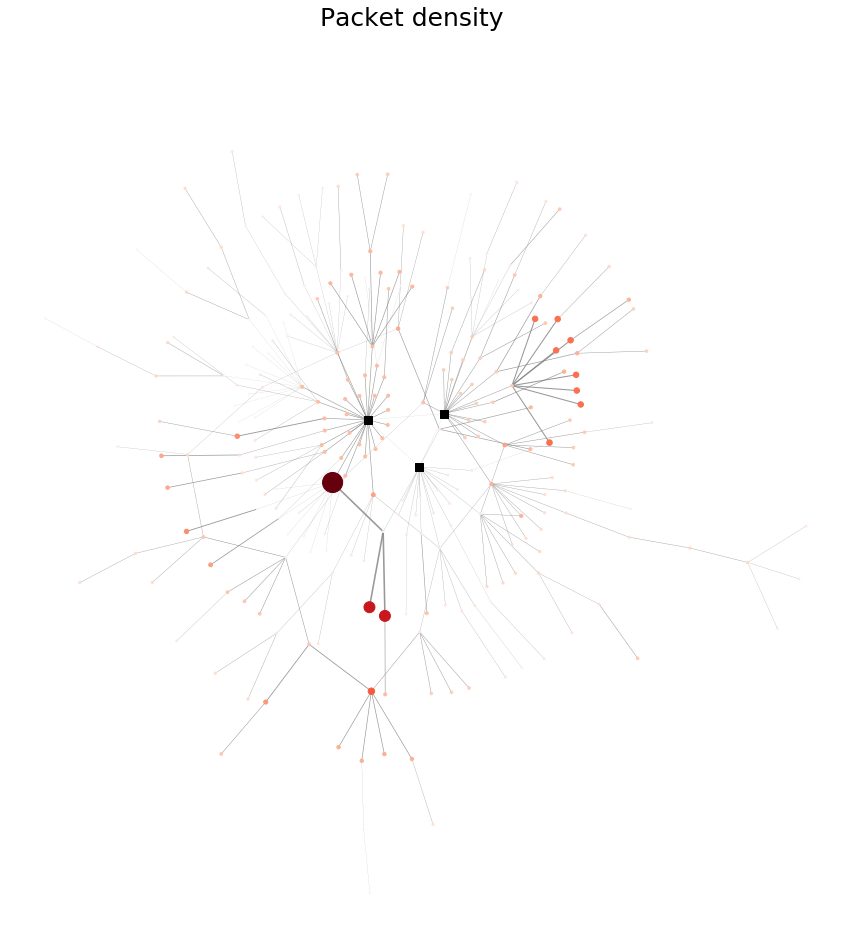

[120.   1. 120.  32.  23. 120.  32. 137. 120. 120.  32. 120.  32.  92.
  32. 120. 105.  23.  45. 115. 120.  92.  32.  91.  92. 105. 120. 196.
  92.  92. 163. 120.  64.   1. 120.  71.  68.   1.  23. 120.  23. 125.
  19.  92.  92. 120. 496.   1.  32.   3.  64. 139.  32. 376.   6.  23.
  64. 239.  92.  71. 271.  23. 239.  92.   1. 135.  32. 165. 120. 142.
   6. 139. 130.  43.  32. 241.  30.  92.  34.  54.  30.  92.  23.  30.
  64.  64.  97.   1. 148. 120.  23.  24.  91.  97. 120. 105.  91.  47.
  36. 120. 130. 103.  68. 104.  64. 105.  92.  23.  65.  38.  30.  71.
  23. 180.   3.  62. 120.   1.  73.  31.   5.  18.  62.  92.  23. 120.
 120.  23. 122. 130. 142.  36.  94.   6.  71.  41.  54.  31.  56.  99.
 120. 239.  71.  10.   1.  31.  94.   1.  68. 130.  77.   1.  30.   6.
  82.   1.  60.  45.  45.  73.   6. 195.  63.  76.  92. 140. 142.  33.
  27.  97.  92. 239.  73.  41.  32.  72.  15.  23. 120. 130.  28. 103.
  23.  62.  32. 120.  45.  64.  36. 142. 120.  71.  34.  20.  40. 103.
  69. 

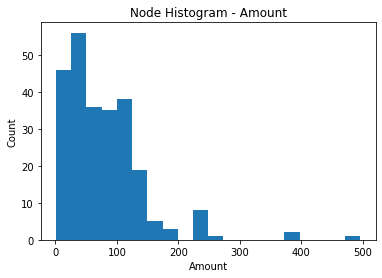

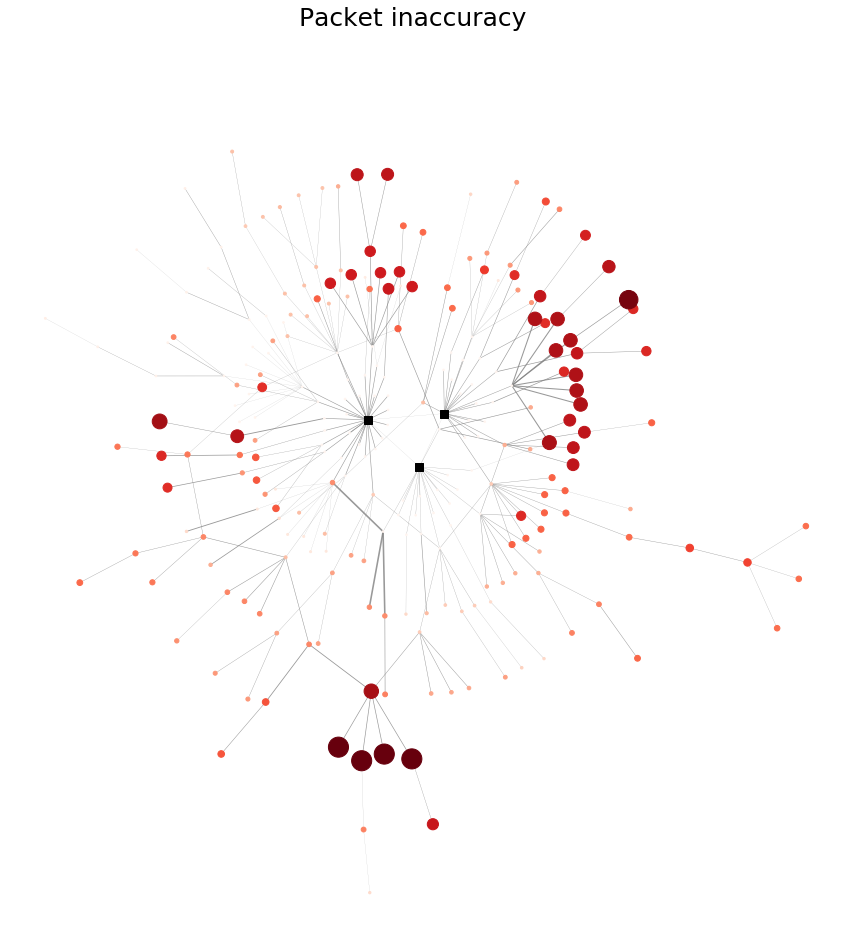

[ 0.          0.55524977  0.          0.         13.59443713  0.
  0.         11.08721857  0.          0.          0.          0.
  0.          0.          0.          0.         23.49937113 13.2021471
 11.08721857 13.59443713  0.          0.          0.         17.61846033
  0.         23.49937113  0.         46.76501729  0.          0.
 16.38955432  0.         29.73957578  0.55524977  0.         16.38955432
 26.12374017  0.55524977 13.2021471   0.         13.2021471  17.06427481
 11.6513386  28.40040518  0.          0.         22.43727445  0.55524977
  0.          3.12786343 29.73957578 44.22084837  0.         22.43727445
  4.52451197 13.2021471  29.73957578 48.02145582  0.         16.38955432
 49.45929735 13.2021471  48.02145582  0.          0.55524977 39.21639884
  0.         11.08721857  0.         56.9878833   4.52451197 44.22084837
 42.14729315 31.35696696  0.         48.73559219 20.42951854  0.
 26.97574644 40.86583253 20.42951854  0.         13.2021471  20.42951854
 29.7395757

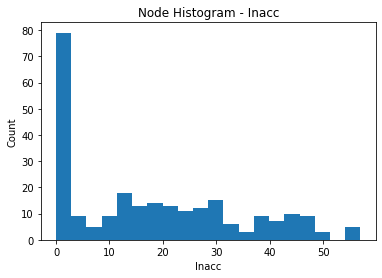

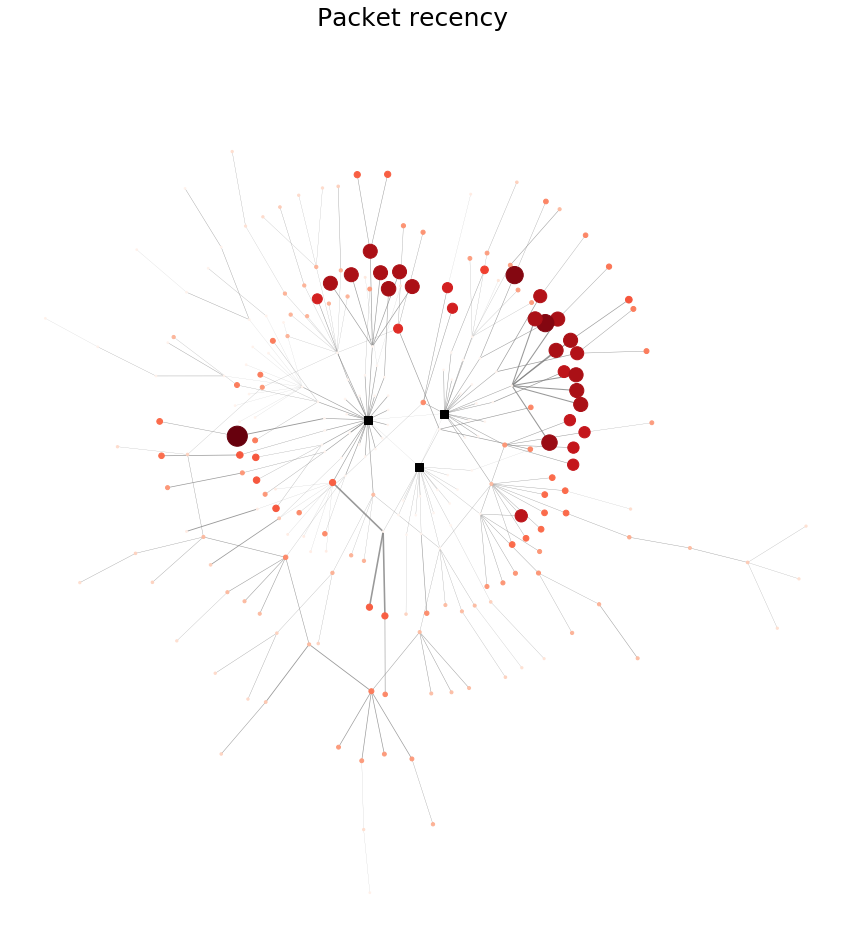

[    0.           489.98854861     0.             0.
 13929.39836239     0.             0.          8619.01264338
     0.             0.             0.             0.
     0.             0.             0.             0.
  8836.22707679  9510.29992215  8619.01264338 13929.39836239
     0.             0.             0.          8398.562425
     0.          8836.22707679     0.         35250.22372388
     0.             0.         12769.10945419     0.
 17512.02816702   489.98854861     0.         12769.10945419
  5987.72393005   489.98854861  9510.29992215     0.
  9510.29992215 14372.67278684  4113.93777099 25611.22021935
     0.             0.         18635.60794974   489.98854861
     0.          2516.20285727 17512.02816702 29187.22359862
     0.         18635.60794974  1774.22506486  9510.29992215
 17512.02816702 30263.60202831     0.         12769.10945419
 15620.58344759  9510.29992215 30263.60202831     0.
   489.98854861 28308.46559579     0.          8619.01264338
     0.      

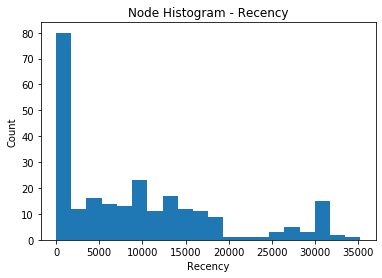

In [8]:
sim.visualize()

In [11]:
misinformation = len([n.get_info_inacc() for n in sim.nodes.values() if n.get_info_inacc() > 0])
print(misinformation)

191


# Testing Hypothesis

* Within log(n) timesteps, at least 50% of nodes will be affected by misinformation
* Simulations with multiple origins will reach majority infection on average faster than a single source, but does not necessarily scale linearly.

### Simulate

In [ ]:
spread_df = pd.DataFrame()
misinfo_df = pd.DataFrame()

# Hyperparameters
runtime = 150
exp_n = 20 # Number of experiments for each source number
node_n = 250 # Number of nodes in graph
pedge = 0.3 # Edge probability when building graph
max_source_count = 25

# Run experiments for difference number of starting sources
for i in range(1,max_source_count+1):
    print(f'Testing with {i} sources')
    spread = []
    misinfo = []
    # Run exp_n experiments per source #
    for j in range(exp_n):
        # Construct and set parameters of simulation
        sim = Simulation()
        sim.num_sources = i
        sim.num_nodes = node_n + i
        sim.pedge = pedge
        sim.generate()
        
        sim.run(runtime)
        spread.append(sim.spread_count)
        misinfo.append(sim.misinfo_count)
    spread_df[str(i) + ' Source'] = np.mean(spread, axis=0)
    misinfo_df[str(i) + ' Source'] = np.mean(misinfo, axis=0)
#     sns.lineplot(x=range(runtime),y=sim.spread_count, legend=i)

Testing with 1 sources
Testing with 2 sources
Testing with 3 sources
Testing with 4 sources


### Information exposure over time

In [ ]:
ax = spread_df.loc[:,['1 Source','3 Source','10 Source', '25 Source']].plot(title= f'Exposure to Information Over Time w/ Edge Probability {pedge}')
ax.axvline(x=np.log(node_n), color='m', label='Hypothesis: ln(n)')
ax.axvline(x=2*np.log(node_n), color='b', label='Hypothesis\': 2ln(n)')
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Nodes Visited")

More sources = faster spread of information

### Misinformation Exposure over time


In [ ]:
ax = misinfo_df.loc[:,['1 Source','3 Source','10 Source', '25 Source']].plot(title= f'Exposure to Misinformation Over Time w/ Edge Probability {pedge}')
ax.axvline(x=np.log(node_n), color='m', label='Hypothesis: ln(n)')
ax.axvline(x=2*np.log(node_n), color='b', label='Hypothesis\': 2ln(n)')
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Nodes Misinformed")

The more sources, the less that are misinformed

### Proportion of Exposed Individuals being Misinformed

In [ ]:
ax = (misinfo_df / spread_df).loc[:,['1 Source','3 Source','10 Source','25 Source']].plot(title= f'% Exposed being Misinformed')
ax.legend()
ax.axvline(x=np.log(node_n), color='m', label='Hypothesis: ln(n)')
ax.axvline(x=2*np.log(node_n), color='b', label='Hypothesis\': 2ln(n)')
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Misinformed")

The more sources, the less that are misinformed

### Relationship between ****source number**** and ****time to reach 50% nodes****

In [ ]:
half_coverage= spread_df.apply(lambda x: (x > 0.5).idxmax())
half_coverage.index = half_coverage.index.str.extract(r'(.+)\s').astype(int)
ax = half_coverage.plot(title='Time until 50% Exposed')
# half_coverage
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Exposed")


In [ ]:
half_exposed= spread_df.apply(lambda x: (x > 0.5).idxmax())
half_misinfo= misinfo_df.apply(lambda x: (x > 0.5).idxmax())

lf_coverage = pd.DataFrame(data={'Exposed':half_exposed, 'Misinformed':half_misinfo}, index = half_exposed.index)
half_coverage.index = half_coverage.index.str.extract(r'(.+)\s').astype(int)

In [ ]:
ax = half_coverage.plot(title='Time Until 50% Affected')
ax.legend()
ax.set_xlabel("Number of Sources")
ax.set_ylabel("Timesteps")

Misinformation slows down drastically as the number of sources increase while information (misinformed or not) is spread at an increasing rate